In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
import numpy as np
import pandas as pd
from pyspark.sql.types import *
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
from pyspark.sql import functions as fn
from pyspark.ml import feature, regression, evaluation, Pipeline
import seaborn as sns
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import OneHotEncoder, OneHotEncoderModel, StringIndexer, VectorAssembler
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext


In [2]:
# Do not delete or change this cell

import os

# Define a function to determine if we are running on data bricks
# Return true if running in the data bricks environment, false otherwise
def is_databricks():
    # get the databricks runtime version
    db_env = os.getenv("DATABRICKS_RUNTIME_VERSION")
    
    # if running on data bricks
    if db_env != None:
        return True
    else:
        return False

# Define a function to read the data file.  The full path data file name is constructed
# by checking runtime environment variables to determine if the runtime environment is 
# databricks, or a student's personal computer.  The full path file name is then
# constructed based on the runtime env.
# 
# Params
#   data_file_name: The base name of the data file to load
# 
# Returns the full path file name based on the runtime env
#
def get_training_filename(data_file_name):    
    # if running on data bricks
    if is_databricks():
        # build the full path file name assuming data brick env
        full_path_name = "/FileStore/tables/%s" % data_file_name
    # else the data is assumed to be in the same dir as this notebook
    else:
        # Assume the student is running on their own computer and load the data
        # file from the same dir as this notebook
        full_path_name = data_file_name
    
    # return the full path file name to the caller
    return full_path_name

In [3]:
# Loading Train data

us_train_cat = spark.read.csv(get_training_filename('USAccident_balanced_train_binary.csv'), header = True, inferSchema = True)

In [4]:
# Number of unique labels in Severity column

us_train_cat.agg(countDistinct("Severity")).show()

+------------------------+
|count(DISTINCT Severity)|
+------------------------+
|                       2|
+------------------------+



In [5]:
# Checking the balance of data in training dataset

us_train_cat.groupBy('Severity').count().show()

+--------+------+
|Severity| count|
+--------+------+
|       1|258685|
|       0|263022|
+--------+------+



In [6]:
# Loading the test data

us_test_cat = spark.read.csv(get_training_filename('USAccident_validation_categorical.csv'), header = True, inferSchema = True)

In [7]:
# Checking the balance of data in testing dataset

us_test_cat.groupBy('Severity').count().show()

+--------+------+
|Severity| count|
+--------+------+
|       3| 58293|
|       4|  6115|
|       2|131571|
+--------+------+



In [8]:
# Vector Assembler to convert all features except Severity to a single column features for feeding it to input of model

va = VectorAssembler().setInputCols([i for i in us_train_cat.columns if i!='Severity']).setOutputCol('features')


# String Indexer to assign target Variable Severity name Label needed for the model to predict

label_stringIdx = StringIndexer(inputCol="Severity", outputCol="label")

In [9]:
# Assigning label of 1 to category 3 and 4 and combine them to make it 1 category for test data

us_test_cat=us_test_cat.withColumn("Severity",when(((us_test_cat["Severity"]==4) | (us_test_cat["Severity"]==3)),1).otherwise(0))

In [10]:
# Evaluator defined for Binary Classification

evaluator_rfb = BinaryClassificationEvaluator(labelCol='label',metricName='areaUnderROC')

# RF Base Model

In [11]:

# Create an initial RandomForest model.
rf = RandomForestClassifier(labelCol="label", featuresCol="features",seed=42)

# Pipeline with stages for fitting the training data

rfModel = Pipeline(stages=[label_stringIdx,va, rf])

In [12]:
# Fit the training data using RF pipeline

rf_fit = rfModel.fit(us_train_cat)

In [13]:
# Predict the test data using fitted train pipeline

pred_rfbb = rf_fit.transform(us_test_cat)

In [14]:
# AUC Score for the test data

print("AUC Score is", evaluator_rfb.evaluate(pred_rfbb))

AUC Score is 0.7688934174044953


In [15]:
# Prediction output from the model to pandas

prediction_rfbb=(pred_rfbb).toPandas()["prediction"]

In [16]:
# True Labels from test data for Target Variable

true_labels=us_test_cat.toPandas()["Severity"]

In [17]:
# Initializing Classification Report from sklearn

from sklearn.metrics import classification_report

In [18]:
# Classification Report Generation for all metrics display at once

print(classification_report(y_pred=prediction_rfbb,y_true=true_labels))

              precision    recall  f1-score   support

           0       0.87      0.59      0.70    131571
           1       0.50      0.82      0.62     64408

   micro avg       0.67      0.67      0.67    195979
   macro avg       0.68      0.71      0.66    195979
weighted avg       0.75      0.67      0.68    195979



In [19]:
# Feature Importance from RF model 

rf_fit.stages[-1].featureImportances

SparseVector(48, {1: 0.0002, 6: 0.0, 8: 0.0, 9: 0.0, 11: 0.0044, 13: 0.0, 14: 0.0001, 16: 0.1117, 17: 0.0001, 18: 0.0, 19: 0.0017, 20: 0.0, 21: 0.0117, 22: 0.0003, 23: 0.0104, 24: 0.0, 25: 0.0492, 26: 0.0, 27: 0.0086, 28: 0.0, 29: 0.0012, 31: 0.0088, 32: 0.0148, 34: 0.2116, 35: 0.0039, 36: 0.0052, 37: 0.0527, 38: 0.2789, 39: 0.0001, 40: 0.001, 41: 0.045, 42: 0.138, 44: 0.0034, 45: 0.0045, 46: 0.0065, 47: 0.0259})

In [20]:
# Creating Pandas Dataframe for Features and their Importance of RF Base Model for Binary Classification

pd.set_option('display.max_rows', None)
feat_imp_tuned_rfbb = pd.DataFrame(list(zip([i for i in us_train_cat.columns if i!='Severity'], rf_fit.stages[-1].featureImportances)),
            columns = ['column', 'weight']).sort_values('weight',ascending=False)

Text(0.5,1,'Top 10 Features based on Importance from Random Forest binary balanced')

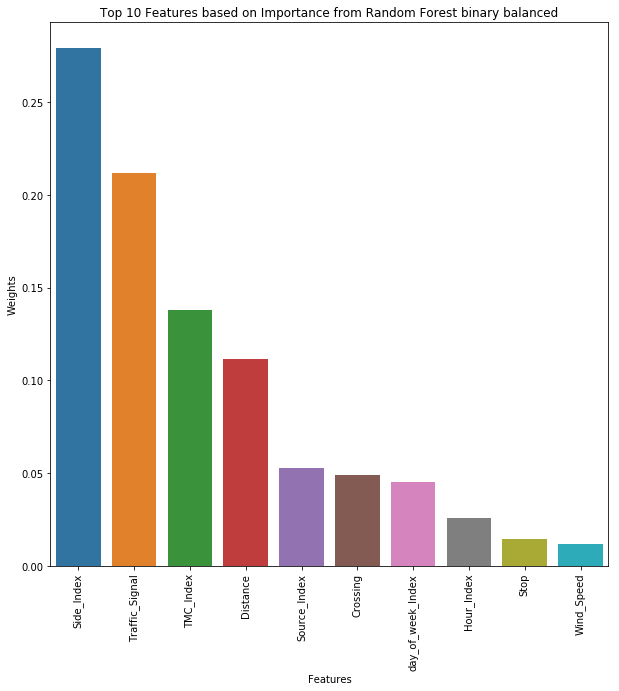

In [21]:
# Plotting top 10 Features from Feature Importance of RF Base Model for Binary Classification

plt.figure(figsize=(10,10))
sns.barplot(x=feat_imp_tuned_rfbb['column'][:10], y=feat_imp_tuned_rfbb['weight'][:10],data=feat_imp_tuned_rfbb)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Weights")
plt.title("Top 10 Features based on Importance from Random Forest binary balanced")

In [22]:
# Accuracy calculation for RF Base Model

true_labels=us_test_cat.toPandas()["Severity"]

binary_prediction=(pred_rfbb).select("prediction").collect()

binary_true_labels=us_test_cat.select("Severity").collect()

np.sum(list([int(binary_true_labels[i][0]==binary_prediction[i][0]) for i in range(len(true_labels))]))/len(true_labels)

0.6671837288689094

# RF Grid Search 

In [23]:

# Create an initial RandomForest model

rf_new = RandomForestClassifier(labelCol="label", featuresCol="features",seed=42)

# Pipeline with stages for RF Grid Search Model

rfModel_new = Pipeline(stages=[label_stringIdx,va, rf_new])

# Grid Search for tuning Hyper parameters 

paramGrid_rft = ParamGridBuilder().addGrid(rf_new.numTrees, [10,25,60]).addGrid(rf_new.maxDepth, [3,6,10]).addGrid(rf_new.impurity,["entropy", "gini"]).build()

In [24]:
# 5-fold Cross Validator Pipeline and fitting the train data using this cv pipeline

cv_rf = CrossValidator(estimator=rfModel_new, estimatorParamMaps=paramGrid_rft, evaluator=evaluator_rfb, numFolds=5,seed=42).fit(us_train_cat)

In [25]:
# Predicting the test data using fitted cv pipeline

pred_rft = cv_rf.transform(us_test_cat)

In [26]:
# AUC Score of tuned RF model

print("AUC Score is", evaluator_rfb.evaluate(pred_rft))

AUC Score is 0.7883950290709438


In [27]:
# Best Model Hyper Parameters after tuning

cv_rf.bestModel.stages[-1].extractParamMap()

{Param(parent='RandomForestClassifier_cd3b39dd9856', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='RandomForestClassifier_cd3b39dd9856', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='RandomForestClassifier_cd3b39dd9856', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'auto',
 Param(parent='RandomForestClassifier_cd3b39dd9856', name='featuresCol', doc='features column name'): 'features',
 Param(parent='RandomForestClassifier_cd3b39dd9856', 

In [28]:
# Best model number of trees parameter from Grid Search

cv_rf.bestModel.stages[-1].getNumTrees

60

In [29]:
# Accuracy of the model on test data

true_labels=us_test_cat.toPandas()["Severity"]

binary_prediction=pred_rft.select("prediction").collect()

binary_true_labels=us_test_cat.select("Severity").collect()

np.sum(list([int(binary_true_labels[i][0]==binary_prediction[i][0]) for i in range(len(true_labels))]))/len(true_labels)

0.6805780211145072

In [30]:
# Prediction output from the model to pandas

prediction_rft=pred_rft.toPandas()["prediction"]

In [31]:
# True Labels from test data for Target Variable

true_labels=us_test_cat.toPandas()["Severity"]

In [32]:
# Initializing Classification Report from sklearn

from sklearn.metrics import classification_report

In [33]:
# Classification Report Generation for all metrics display at once

print(classification_report(y_pred=prediction_rft,y_true=true_labels))

              precision    recall  f1-score   support

           0       0.88      0.61      0.72    131571
           1       0.51      0.83      0.63     64408

   micro avg       0.68      0.68      0.68    195979
   macro avg       0.69      0.72      0.67    195979
weighted avg       0.76      0.68      0.69    195979



In [34]:
# Creating Pandas Dataframe for Features and their Importance of RF Grid Model for Binary Classification

pd.set_option('display.max_rows', None)
feat_imp_tuned_rfg = pd.DataFrame(list(zip([i for i in us_train_cat.columns if i!='Severity'], cv_rf.bestModel.stages[-1].featureImportances)),
            columns = ['column', 'weight']).sort_values('weight',ascending=False)

Text(0.5,1,'Top 10 Features based on Importance from Random Forest Grid')

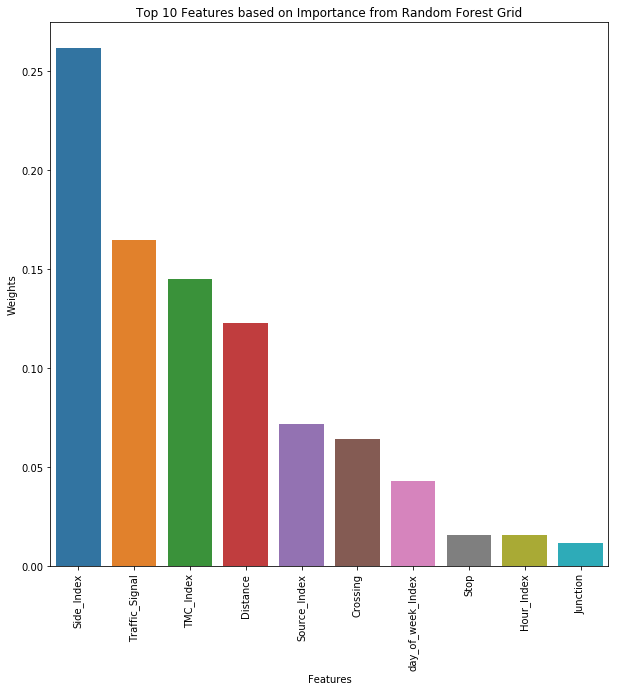

In [35]:
# Plotting top 10 Features from Feature Importance of RF Grid Model for Binary Classification

plt.figure(figsize=(10,10))
sns.barplot(x=feat_imp_tuned_rfg['column'][:10], y=feat_imp_tuned_rfg['weight'][:10],data=feat_imp_tuned_rfg)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Weights")
plt.title("Top 10 Features based on Importance from Random Forest Grid")

# GBT Base Model

In [36]:
# Initialize the GBT Base model

gbt = GBTClassifier(seed=42)

In [37]:
# Pipeline with stages to be used to fit the train data

gbt_pipe = Pipeline(stages=[label_stringIdx, va, gbt])

In [38]:
# Fitting the training data using the pipeline above

gbtModel = gbt_pipe.fit(us_train_cat)

In [39]:
# AUC Score from the model on the test data

print("AUC Score is", evaluator_rfb.evaluate(gbtModel.transform(us_test_cat)))

AUC Score is 0.7906177407137301


In [40]:
# Prediction output from the model to pandas

prediction_gbtn=(gbtModel.transform(us_test_cat)).toPandas()["prediction"]

In [41]:
# True labels from the test data for the target variable

true_labels=us_test_cat.toPandas()["Severity"]

In [42]:
# Initializing Classification Report from sklearn

from sklearn.metrics import classification_report

In [43]:
# Classification Report Generation for all metrics display at once

print(classification_report(y_pred=prediction_gbtn,y_true=true_labels))

              precision    recall  f1-score   support

           0       0.88      0.60      0.71    131571
           1       0.51      0.84      0.63     64408

   micro avg       0.68      0.68      0.68    195979
   macro avg       0.69      0.72      0.67    195979
weighted avg       0.76      0.68      0.69    195979



In [44]:
# Accuracy of the model on test data
pred=gbtModel.transform(us_test_cat)

true_labels=us_test_cat.toPandas()["Severity"]

binary_prediction=pred.select("prediction").collect()

binary_true_labels=us_test_cat.select("Severity").collect()

np.sum(list([int(binary_true_labels[i][0]==binary_prediction[i][0]) for i in range(len(true_labels))]))/len(true_labels)

0.677955291128131

In [44]:
# Creating Pandas Dataframe for Features and their Importance of GBT Base Model for Binary Classification

pd.set_option('display.max_rows', None)
feat_imp_tuned_gtbb = pd.DataFrame(list(zip([i for i in us_train_cat.columns if i!='Severity'], gbtModel.stages[-1].featureImportances)),
            columns = ['column', 'weight']).sort_values('weight',ascending=False)

Text(0.5,1,'Top 10 Features based on Importance from GBT Base Model')

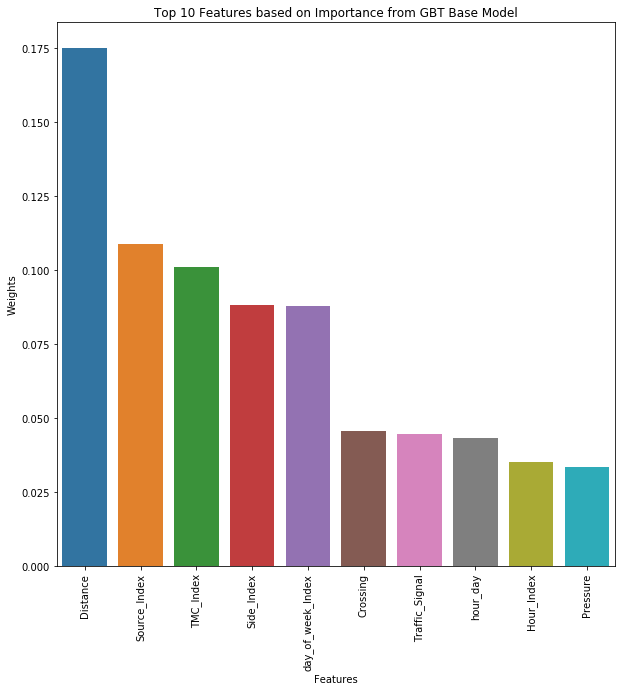

In [45]:
# Plotting top 10 Features from Feature Importance of GBT Base Model for Binary Classification

plt.figure(figsize=(10,10))
sns.barplot(x=feat_imp_tuned_gtbb['column'][:10], y=feat_imp_tuned_gtbb['weight'][:10],data=feat_imp_tuned_gtbb)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Weights")
plt.title("Top 10 Features based on Importance from GBT Base Model")

# GBT Binary Classification Grid Search

# GBT Binary Tuned Best Model

In [45]:

# Initializing GBT Grid Pipeline 

gbt_t_new = GBTClassifier(maxIter=55,seed=42)

# Creating pipeline for GBT grid Model 

gbt_pipe_t_new = Pipeline(stages=[label_stringIdx, va, gbt_t_new])

# Binary Classification Evaluator

evaluator = BinaryClassificationEvaluator(labelCol='label',metricName='areaUnderROC')

# Creating Grid Search for Hyper Parameter Tuning for GBT model

grid_gbt_t_new = ParamGridBuilder().addGrid(gbt_t_new.stepSize, [0.2,0.4,0.01]).addGrid(gbt_t_new.maxDepth, [3, 5, 8]).build()

# Cross Validator Pipeline with 5 fold cv to fit the training data

cv1_gbt_t_new = CrossValidator(estimator=gbt_pipe_t_new,estimatorParamMaps=grid_gbt_t_new, numFolds=5, evaluator=evaluator,seed=42)

In [46]:
# Fitting train data using 5-fold cross validator pipeline

cvModel_gbt_t_new = cv1_gbt_t_new.fit(us_train_cat)

In [47]:
# AUC Score from the fitted pipeline for the test data

print("AUC Score is", evaluator.evaluate(cvModel_gbt_t_new.transform(us_test_cat)))

AUC Score is 0.8029201482369708


In [48]:
# AUC Score from the Cross validator Pipeline

np.max(cvModel_gbt_t_new.avgMetrics)

0.8012168000504416

In [49]:
# Hyper pramaters from the best model 

cvModel_gbt_t_new.bestModel.stages[-1].extractParamMap()

{Param(parent='GBTClassifier_9bc66308c04c', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='GBTClassifier_9bc66308c04c', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='GBTClassifier_9bc66308c04c', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'all',
 Param(parent='GBTClassifier_9bc66308c04c', name='featuresCol', doc='features column name'): 'features',
 Param(parent='GBTClassifier_9bc66308c04c', name='labelCol', doc='label column name'): 'la

In [50]:
# Prediction output from the model to pandas

prediction_gbt_t_new=cvModel_gbt_t_new.transform(us_test_cat).toPandas()["prediction"]

In [51]:
# True Labels from test data for Target Variable

true_labels=us_test_cat.toPandas()["Severity"]

In [52]:
# Initializing Classification Report from sklearn

from sklearn.metrics import classification_report

In [53]:
# Classification Report Generation for all metrics display at once

print(classification_report(y_pred=prediction_gbt_t_new,y_true=true_labels))

              precision    recall  f1-score   support

           0       0.87      0.65      0.75    131571
           1       0.53      0.81      0.64     64408

   micro avg       0.70      0.70      0.70    195979
   macro avg       0.70      0.73      0.69    195979
weighted avg       0.76      0.70      0.71    195979



In [54]:
# Accuracy of the model on test data
pred=cvModel_gbt_t_new.transform(us_test_cat)

true_labels=us_test_cat.toPandas()["Severity"]

binary_prediction=pred.select("prediction").collect()

binary_true_labels=us_test_cat.select("Severity").collect()

np.sum(list([int(binary_true_labels[i][0]==binary_prediction[i][0]) for i in range(len(true_labels))]))/len(true_labels)

0.702065017170207

In [55]:
# Creating Pandas Dataframe for Features and their Importance of GBT Grid Model for Binary Classification

pd.set_option('display.max_rows', None)
feat_imp_tuned_gbt_t_new = pd.DataFrame(list(zip([i for i in us_train_cat.columns if i!='Severity'], cvModel_gbt_t_new.bestModel.stages[-1].featureImportances)),
            columns = ['column', 'weight']).sort_values('weight',ascending=False)

Text(0.5,1,'Top 10 Features based on Importance from GBT Best tuned')

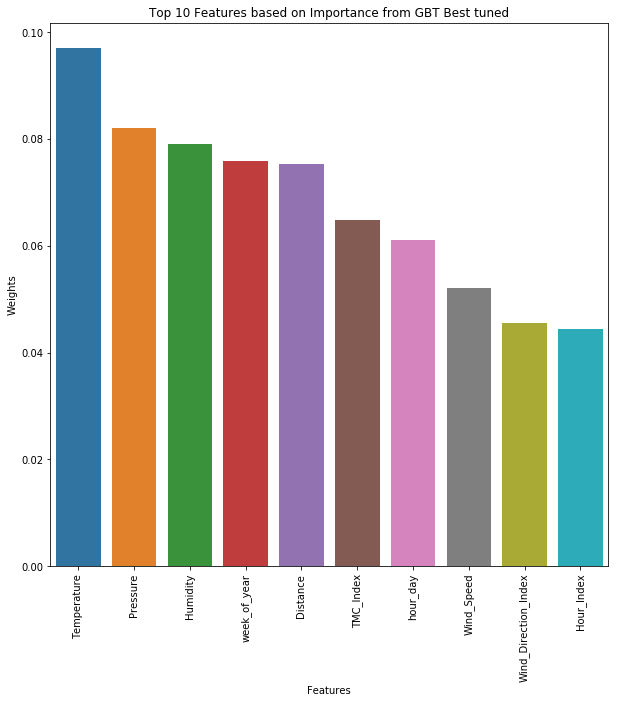

In [56]:
# Plotting top 10 Features from Feature Importance of GBT Grid Model for Binary Classification

plt.figure(figsize=(10,10))
sns.barplot(x=feat_imp_tuned_gbt_t_new['column'][:10], y=feat_imp_tuned_gbt_t_new['weight'][:10],data=feat_imp_tuned_gbt_t_new)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Weights")
plt.title("Top 10 Features based on Importance from GBT Best tuned")

# Decision Trees Binary Classification Base Model

In [57]:

# Create initial Decision Tree Model
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features",seed=42)

# Pipeline with stages created for DT Model 

dt_pipe = Pipeline(stages=[label_stringIdx, va, dt])

# Train model with Training Data

dtModel = dt_pipe.fit(us_train_cat)

In [58]:
# Binary Class Evaluator Initialize

evaluator = BinaryClassificationEvaluator(labelCol='label',metricName='areaUnderROC')

In [59]:
# Transform the test data to get prediction from the model for the test data

pred_dt = dtModel.transform(us_test_cat)

In [60]:
# AUC Score from the evaluator for the test data

print("AUC Score is",evaluator.evaluate(pred_dt))

AUC Score is 0.6780653504241498


In [61]:
# Accuracy Calculation for DT Base Model

binary_prediction=pred_dt.select("prediction").collect()

binary_true_labels=us_test_cat.select("Severity").collect()

np.sum(list([int(binary_true_labels[i][0]==binary_prediction[i][0]) for i in range(len(true_labels))]))/len(true_labels)

0.6575398384520791

In [62]:
# Prediction output from the model to pandas

prediction_dtb=pred_dt.toPandas()["prediction"]

In [63]:
# True Labels from test data for Target Variable

true_labels=us_test_cat.toPandas()["Severity"]

In [64]:
# Initializing Classification Report from sklearn

from sklearn.metrics import classification_report

In [65]:
# Classification Report Generation for all metrics display at once

print(classification_report(y_pred=prediction_dtb,y_true=true_labels))

              precision    recall  f1-score   support

           0       0.87      0.57      0.69    131571
           1       0.49      0.83      0.61     64408

   micro avg       0.66      0.66      0.66    195979
   macro avg       0.68      0.70      0.65    195979
weighted avg       0.75      0.66      0.67    195979



In [66]:
# Creating Pandas Dataframe for Features and their Importance of DT Base Model for Binary Classification

pd.set_option('display.max_rows', None)
feat_imp_tuned_dtb= pd.DataFrame(list(zip([i for i in us_train_cat.columns if i!='Severity'], dtModel.stages[-1].featureImportances)),
            columns = ['column', 'weight']).sort_values('weight',ascending=False)

Text(0.5,1,'Top 10 Features based on Importance from DT Binary Base Model')

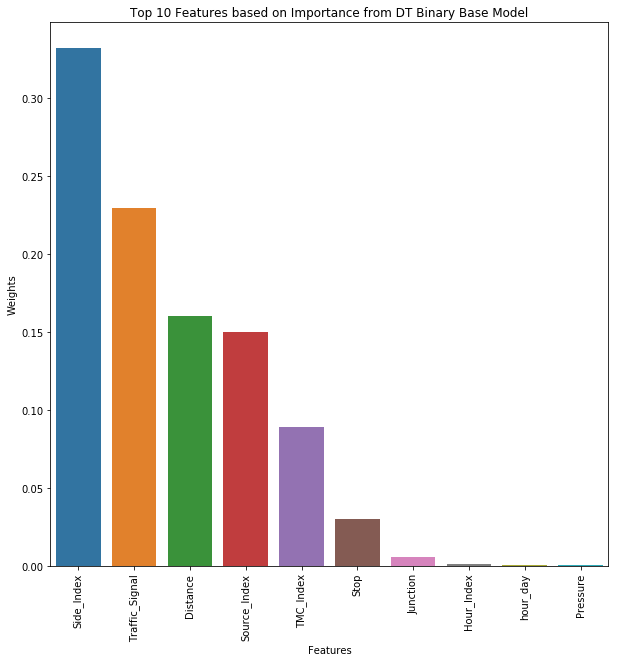

In [67]:
# Plotting top 10 Features from Feature Importance of DT Base Model for Binary Classification

plt.figure(figsize=(10,10))
sns.barplot(x=feat_imp_tuned_dtb['column'][:10], y=feat_imp_tuned_dtb['weight'][:10],data=feat_imp_tuned_dtb)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Weights")
plt.title("Top 10 Features based on Importance from DT Binary Base Model")

# Decision Tree Binary Classification Grid Search

In [55]:
# Initializing DT Grid Pipeline

dt_new = DecisionTreeClassifier(labelCol="label", featuresCol="features",seed=42)

# Creating pipeline for DT Grid Model 

dt_new_pipe = Pipeline(stages=[label_stringIdx, va, dt_new])

# Binary Evaluator Initializing

evaluator = BinaryClassificationEvaluator(labelCol='label',metricName='areaUnderROC')

# Creating Grid Search for Hyper Parameter Tuning for DT Model

grid_dt = ParamGridBuilder().addGrid(dt_new.maxDepth, [5,10,15,30]).addGrid(dt_new.minInstancesPerNode, [1,500,1000,1500]).addGrid(dt_new.maxBins,[20,32,50]).build()

# Cross Validator Pipeline with 5 fold cv to fit the training data

cv1_dt = CrossValidator(estimator=dt_new_pipe,estimatorParamMaps=grid_dt, numFolds=5, evaluator=evaluator,seed=42)

In [56]:
# Fitting the train data using the 5-fold Cross validator pipeline

dtModel_t = cv1_dt.fit(us_train_cat)

In [57]:
# Predicting the test data using the fitted pipeline

pred_dtt = dtModel_t.transform(us_test_cat)

In [58]:
# AUC Score for the fitted pipeline for test data

print("AUC Score", evaluator.evaluate(pred_dtt))

AUC Score 0.6787710232169517


In [59]:
# Best Model Hyper parameters for the DT Grid Search Model

dtModel_t.bestModel.stages[-1].extractParamMap()

{Param(parent='DecisionTreeClassifier_90801e1fc7bf', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='DecisionTreeClassifier_90801e1fc7bf', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='DecisionTreeClassifier_90801e1fc7bf', name='featuresCol', doc='features column name'): 'features',
 Param(parent='DecisionTreeClassifier_90801e1fc7bf', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini'): 'gini',
 Param(parent='DecisionTreeClassifier_90801e1fc7bf', name='labelCol', doc='label column name'): 'lab

In [60]:
# Prediction output from the model to pandas

prediction_dtbt=pred_dtt.toPandas()["prediction"]

In [61]:
# True Labels from test data for Target Variable

true_labels=us_test_cat.toPandas()["Severity"]

In [62]:
# Initializing Classification Report from sklearn

from sklearn.metrics import classification_report

In [63]:
# Classification Report Generation for all metrics display at once

print(classification_report(y_pred=prediction_dtbt,y_true=true_labels))

              precision    recall  f1-score   support

           0       0.87      0.58      0.70    131571
           1       0.49      0.82      0.61     64408

   micro avg       0.66      0.66      0.66    195979
   macro avg       0.68      0.70      0.65    195979
weighted avg       0.74      0.66      0.67    195979



In [64]:
pred_dt = dtModel_t.transform(us_test_cat)

In [65]:
binary_prediction=pred_dt.select("prediction").collect()

binary_true_labels=us_test_cat.select("Severity").collect()

np.sum(list([int(binary_true_labels[i][0]==binary_prediction[i][0]) for i in range(len(true_labels))]))/len(true_labels)

0.6599992856377469

In [66]:
# Creating Pandas Dataframe for Features and their Importance of DT Grid Model for Binary Classification

pd.set_option('display.max_rows', None)
feat_imp_tuned_dtbt= pd.DataFrame(list(zip([i for i in us_train_cat.columns if i!='Severity'], dtModel_t.bestModel.stages[-1].featureImportances)),
            columns = ['column', 'weight']).sort_values('weight',ascending=False)

Text(0.5,1,'Top 10 Features based on Importance from DT Binary Grid Model')

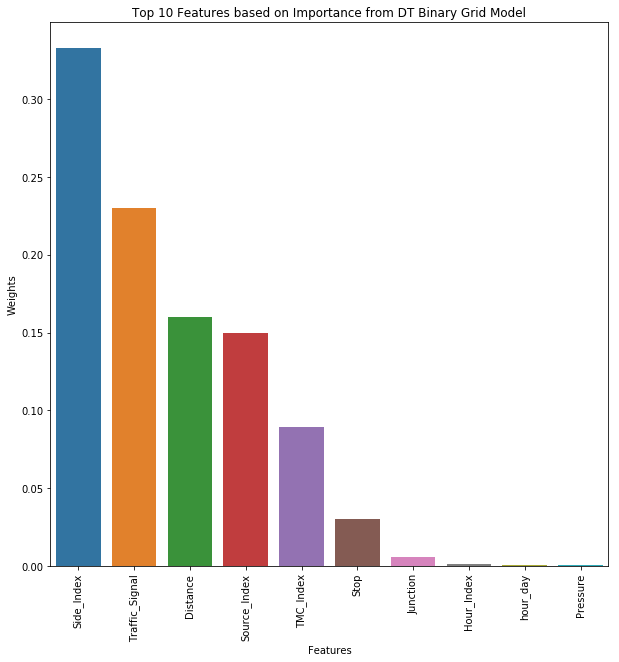

In [67]:
# Plotting top 10 Features from Feature Importance of DT Grid Model for Binary Classification

plt.figure(figsize=(10,10))
sns.barplot(x=feat_imp_tuned_dtbt['column'][:10], y=feat_imp_tuned_dtbt['weight'][:10],data=feat_imp_tuned_dtbt)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Weights")
plt.title("Top 10 Features based on Importance from DT Binary Grid Model")

# Logistic Regression 

# Logistic Base Model Binary

In [68]:
us_train_cat = spark.read.csv(get_training_filename('USAccident_balanced_train_binary_OHE.csv'), header = True, inferSchema = True)

In [69]:
us_test_cat = spark.read.csv(get_training_filename('USAccident_validation_OHE.csv'), header = True, inferSchema = True)

In [70]:
us_test_cat=us_test_cat.withColumn("Severity",when(((us_test_cat["Severity"]==4) | (us_test_cat["Severity"]==3)),1).otherwise(0))

In [71]:
us_train_cat=us_train_cat.drop("hour_day","week_of_year")

In [72]:
# Standard Scaler to standardize the output of vector assembler before feeding it to Logistic Regression

center = feature.StandardScaler(withMean=True, withStd=False, inputCol='features', outputCol='centered_features')

In [73]:
# Vector Assembler to convert all features except Severity to a single column features for feeding it to input of model

va = VectorAssembler().setInputCols([i for i in us_train_cat.columns if i!='Severity']).setOutputCol('features')


# String Indexer to assign target Variable Severity name Label needed for the model to predict

label_stringIdx = StringIndexer(inputCol="Severity", outputCol="label")

In [74]:
# Create initial LogisticRegression model
lr = LogisticRegression(labelCol="label", featuresCol="centered_features")

# Pipeline for training data 

lrModel = Pipeline(stages=[label_stringIdx,va, center, lr])

# Fit the train data using LR model

lr_fit = lrModel.fit(us_train_cat)

In [75]:
# Transsform test data to predict Severity by using fitted pipeline from training data

pred_lrb = lr_fit.transform(us_test_cat)

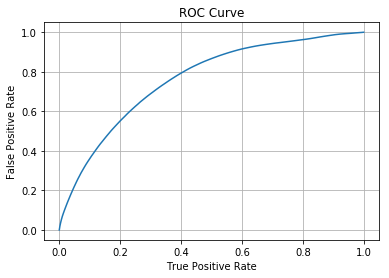

Training set areaUnderROC: 0.7616892787379583


In [76]:
# ROC Curve for LR Base Model

trainingSummary = lr_fit.stages[-1].summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [77]:
# Logistic Regression Coefficients to Array 

coef_l1=lr_fit.stages[-1].coefficientMatrix.toArray()

In [78]:
# to stack the coefficient array column wise for further analysis

cof_l1=np.hstack(coef_l1)

In [79]:
# Creating pandas dataframe with Logistic Regression weights for each variable along with variable name

pd.set_option('display.max_rows', None)
feat_imp_tuned_b = pd.DataFrame(list(zip([i for i in us_train_cat.columns if i!='Severity'], cof_l1)),
            columns = ['column', 'weight']).sort_values('weight',ascending=False)

In [80]:
# Coefficient from LR model for each variable

coef_L1=lr_fit.stages[-1].coefficients.toArray()

In [81]:
coef_L1

array([ 8.32414716e-02,  4.01885638e-01,  6.06014319e-01,  4.06878587e-02,
        1.39054365e-01,  7.03929433e-01,  2.64762270e-01,  6.42031187e-01,
        3.01237660e-01,  8.07168543e-01,  6.80979735e-01,  3.43706679e-01,
        3.51226413e-01,  3.58182197e-01,  2.95572524e-01,  3.74042119e-01,
        1.83091789e-01,  7.44692552e-01,  4.37326137e-01,  3.42266997e-01,
        8.16334031e-02,  4.97154012e-01,  2.02295143e-01,  4.12047632e-02,
        5.34422141e-02, -1.70019642e-02,  2.70259376e-02,  1.84906022e+00,
        6.54736535e-01,  8.21394557e-01, -2.86284680e-01,  4.35472054e-01,
        1.17705434e+00,  8.18692241e+00, -3.71764933e-01,  1.46678435e+00,
       -4.63816470e-01,  8.65245717e-01,  5.81592058e-01, -3.13552259e-01,
        9.09807262e-01,  9.33719767e-01,  4.11795463e-01,  9.01476714e-01,
       -4.91801998e-02,  1.87667250e+00,  9.38419001e-01,  5.90707067e-01,
        5.22631700e-02,  1.40200378e-02,  3.17342220e-02, -5.48145319e-03,
        6.97646738e-01,  

In [82]:
# Taking absolute values of weights and calculating the number of features eliminated by LR Model after L1 regularization 

coef_L1 = np.absolute(coef_L1)

print('Total number of features are',len(coef_L1))

sorted_abs = np.sort(coef_L1)

weights_notzero = sorted_abs[sorted_abs == 0]
nonzero_weights = len(sorted_abs[sorted_abs == 0])

print('Eliminated features out of ' + str(len(coef_L1)) + ' are', nonzero_weights)


Total number of features are 120
Eliminated features out of 120 are 0


In [83]:
# Prediction output from the model to pandas

prediction_lrbal=pred_lrb.toPandas()["prediction"]

In [84]:
# True Labels from test data for Target Variable

true_labels=us_test_cat.toPandas()["Severity"]

In [85]:
# Initializing Classification Report from sklearn

from sklearn.metrics import classification_report

In [86]:
# Classification Report Generation for all metrics display at once

print(classification_report(y_pred=prediction_lrbal,y_true=true_labels))

              precision    recall  f1-score   support

           0       0.85      0.63      0.72    131790
           1       0.50      0.77      0.61     64610

   micro avg       0.67      0.67      0.67    196400
   macro avg       0.67      0.70      0.66    196400
weighted avg       0.73      0.67      0.68    196400



In [89]:
np.sum(list([int(true_labels[i]==prediction_lrbal[i]) for i in range(len(true_labels))]))/len(true_labels)

0.6730702647657841

# Logistic Binary Grid Search Binary

In [90]:
# Logistic Regression Pipeline initialization

lr_new = LogisticRegression(labelCol="label", featuresCol="centered_features")

In [91]:
# Grid Search for tuning the hyper parameters of Logistic Regression Model

paramGrid_lr = ParamGridBuilder().addGrid(lr_new.regParam, [0,0.1, 0.4,0.7]).addGrid(lr_new.elasticNetParam, [0.1,0.4,0.7]).build()

In [92]:
# Creating pipeline to be used for fitting the training data

cvModel_lrbal = Pipeline(stages=[label_stringIdx,va,center,lr_new])

In [93]:
# Initializing Binary Evaluator for evaluating the model performance

evaluator_lrbt = BinaryClassificationEvaluator(labelCol='label',metricName='areaUnderROC')

In [94]:
# Cross validator pipeline initialization for 5-fold cross validation and fitting the train data

cv_lrbal = CrossValidator(estimator=cvModel_lrbal, estimatorParamMaps=paramGrid_lr, evaluator=evaluator_lrbt, numFolds=5,seed=42).fit(us_train_cat)

In [95]:
# Testing the test data on fitted 5 fold cv pipeline

pred_lrbalt=cv_lrbal.transform(us_test_cat)

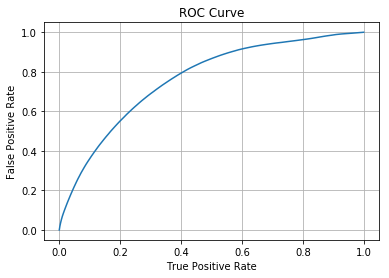

Training set areaUnderROC: 0.761683026335512


In [96]:
# ROC Curve for Logistic Regression Grid Search Model

trainingSummary_t = cv_lrbal.bestModel.stages[-1].summary
roc = trainingSummary_t.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary_t.areaUnderROC))

In [97]:
# Best Model Hyper parameters after Tuning LR Model

cv_lrbal.bestModel.stages[-1].extractParamMap()

{Param(parent='LogisticRegression_a1e53c0ffa48', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2,
 Param(parent='LogisticRegression_a1e53c0ffa48', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.4,
 Param(parent='LogisticRegression_a1e53c0ffa48', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial.'): 'auto',
 Param(parent='LogisticRegression_a1e53c0ffa48', name='featuresCol', doc='features column name'): 'centered_features',
 Param(parent='LogisticRegression_a1e53c0ffa48', name='fitIntercept', doc='whether to fit an intercept term'): True,
 Param(parent='LogisticRegression_a1e53c0ffa48', name='labelCol', doc='label column name'): 'label',
 Param(parent='LogisticRegression_a1e53c0ffa48', name='maxIter', doc='maximum number of iterations (

In [98]:
# Accuracy Calculation for the test data from the model

binary_prediction=pred_lrbalt.select("prediction").collect()

binary_true_labels=us_test_cat.select("Severity").collect()

np.sum(list([int(binary_true_labels[i][0]==binary_prediction[i][0]) for i in range(len(true_labels))]))/len(true_labels)

0.6730702647657841

In [99]:
# Prediction output from the model to pandas

prediction_lrbalt=pred_lrbalt.toPandas()["prediction"]

In [100]:
# True Labels from test data for Target Variable

true_labels=us_test_cat.toPandas()["Severity"]

In [101]:
# Initializing Classification Report from sklearn

from sklearn.metrics import classification_report

In [102]:
# Classification Report Generation for all metrics display at once

print(classification_report(y_pred=prediction_lrbalt,y_true=true_labels))

              precision    recall  f1-score   support

           0       0.85      0.63      0.72    131790
           1       0.50      0.77      0.61     64610

   micro avg       0.67      0.67      0.67    196400
   macro avg       0.67      0.70      0.66    196400
weighted avg       0.73      0.67      0.68    196400



In [103]:
# Coefficient from LR model for each variable

coef_L1_m=cv_lrbal.bestModel.stages[-1].coefficients.toArray()

In [104]:
coef_L1_m

array([ 8.32414716e-02,  4.01885638e-01,  6.06014319e-01,  4.06878588e-02,
        1.39054365e-01,  7.03929433e-01,  2.64762270e-01,  6.42031186e-01,
        3.01237660e-01,  8.07168543e-01,  6.80979735e-01,  3.43706679e-01,
        3.51226413e-01,  3.58182197e-01,  2.95572524e-01,  3.74042119e-01,
        1.83091789e-01,  7.44692551e-01,  4.37326137e-01,  3.42266997e-01,
        8.16334031e-02,  4.97154012e-01,  2.02295143e-01,  4.12047631e-02,
        5.34422144e-02, -1.70019635e-02,  2.70259371e-02,  1.84906022e+00,
        6.54736535e-01,  8.21394557e-01, -2.86284679e-01,  4.35472054e-01,
        1.17705434e+00,  8.18692168e+00, -3.71764933e-01,  1.46678435e+00,
       -4.63816470e-01,  8.65245717e-01,  5.81592059e-01, -3.13552259e-01,
        9.09807262e-01,  9.33719767e-01,  4.11795464e-01,  9.01476714e-01,
       -4.91801997e-02,  1.87667250e+00,  9.38419001e-01,  5.90707067e-01,
        5.22631699e-02,  1.40200378e-02,  3.17342220e-02, -5.48145326e-03,
        6.97646738e-01,  

In [105]:
# Pandas dataframe of weights of variables with variable names to find which variables are eliminated

feat_imp_tuned_lrt = pd.DataFrame(list(zip([i for i in us_train_cat.columns if i!='Severity'], np.absolute(coef_L1_m))),
            columns = ['column', 'weight']).sort_values('weight')

In [106]:
# Sample of 10 features eliminated by the Logistic Regression Model after L1 Regularization

feat_imp_tuned_lrt[:10]

,column,weight
103,Humidity,0.000094
60,month_of_year_Index_2,0.003547
102,Temperature,0.004144
51,day_of_week_Index_2,0.005481
81,Wind_Direction_Index_12,0.006202
78,Wind_Direction_Index_15,0.006762
74,Wind_Direction_Index_10,0.008885
67,Wind_Direction_Index_1,0.009155
106,Wind_Speed,0.009511
49,day_of_week_Index_4,0.014020


In [107]:
# Taking absolute values of weights and calculating the number of features eliminated by LR Model after L1 regularization 

coef_L1_m = np.absolute(coef_L1_m)

print('Total number of features are',len(coef_L1_m))

sorted_abs = np.sort(coef_L1_m)

weights_notzero = sorted_abs[sorted_abs == 0]
nonzero_weights = len(sorted_abs[sorted_abs == 0])

print('Eliminated features out of ' + str(len(coef_L1_m)) + ' are', len(weights_notzero))

Total number of features are 120
Eliminated features out of 120 are 0
